## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-06-16 21:28:50.451 | INFO     |  Running on cpu


In [3]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'CloseCabinet'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


2025-06-16 21:28:53.480 | INFO     |  Loading dataset(s): 
2025-06-16 21:28:53.481 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/CloseCabinet/demos/metadata.json
2025-06-16 21:28:53.482 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-06-16 21:28:53.482 | INFO     |    Extracted tsdf object labels []
2025-06-16 21:28:53.482 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=to

In [4]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([162, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([162]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([162, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([162, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([162, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([162, 3, 256, 256]), device=cpu, dt

In [6]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2, # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation
    drop_redundant_frames=True,

)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.001,
    components_prop_to_len=True,
    min_end_distance=20,
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-06-16 21:29:00.602 | INFO     |  Fitting AutoTPGMM
2025-06-16 21:29:00.603 | INFO     |  Performing fitting actions: [INIT]
2025-06-16 21:29:00.603 | INFO     |  Segmenting trajectories


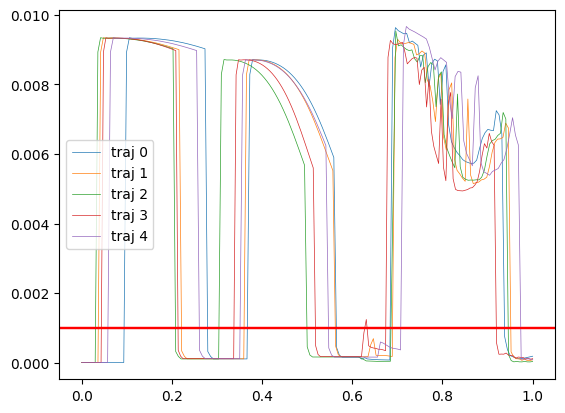

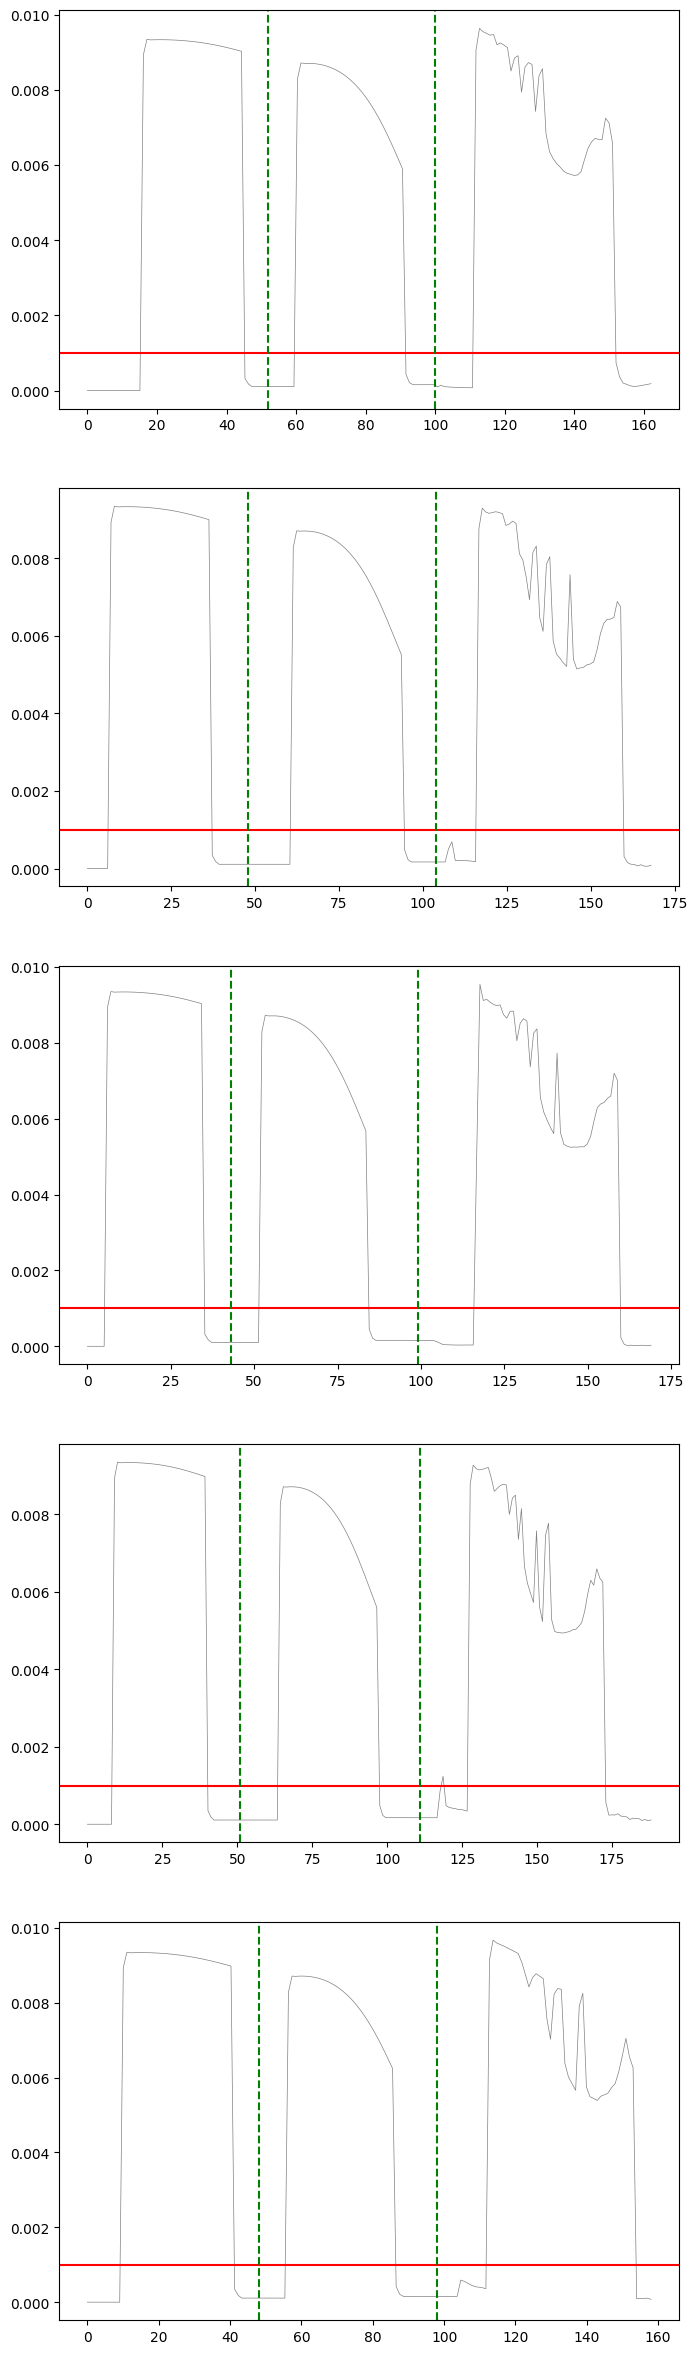

2025-06-16 21:29:01.429 | INFO     |  Creating segement of demos.
2025-06-16 21:29:01.435 | INFO     |  Subsampling to length 57 using strategy mean-length.
2025-06-16 21:29:01.436 | INFO     |  Creating segement of demos.
2025-06-16 21:29:01.442 | INFO     |  Subsampling to length 63 using strategy mean-length.
2025-06-16 21:29:01.443 | INFO     |  Creating segement of demos.
2025-06-16 21:29:01.450 | INFO     |  Subsampling to length 75 using strategy mean-length.
2025-06-16 21:29:01.451 | INFO     |  ... created 3 segments
2025-06-16 21:29:01.451 | INFO     |    Fitting candidate frame 1/10
2025-06-16 21:29:01.451 | INFO     |    Creating partial frame view of demos.
2025-06-16 21:29:01.457 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-06-16 21:29:01.457 | INFO     |    Changing number of components to 2
2025-06-16 21:29:01.457 | INFO     |    Init strategy not specified. Auto selected InitStrategy.TIME_BASED.
2025-06-16 21:29:01.457 | INFO     |    Model init ...


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:01.610 | INFO     |    Fitting candidate frame 2/10
2025-06-16 21:29:01.610 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:01.799 | INFO     |    Fitting candidate frame 3/10
2025-06-16 21:29:01.800 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:02.051 | INFO     |    Fitting candidate frame 4/10
2025-06-16 21:29:02.052 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:02.255 | INFO     |    Fitting candidate frame 5/10
2025-06-16 21:29:02.255 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:02.443 | INFO     |    Fitting candidate frame 6/10
2025-06-16 21:29:02.443 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:02.663 | INFO     |    Fitting candidate frame 7/10
2025-06-16 21:29:02.663 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:02.886 | INFO     |    Fitting candidate frame 8/10
2025-06-16 21:29:02.886 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:03.271 | INFO     |    Fitting candidate frame 9/10
2025-06-16 21:29:03.271 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:03.671 | INFO     |    Fitting candidate frame 10/10
2025-06-16 21:29:03.671 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:03.989 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-06-16 21:29:03.989 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-06-16 21:29:03.990 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-06-16 21:29:03.990 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-06-16 21:29:03.990 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-06-16 21:29:03.990 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-06-16 21:29:03.990 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-06-16 21:29:03.990 | INFO     |  obj006     score (rel):     -0 (0.000)
2025-06-16 21:29:03.990 | INFO     |  obj007     score (rel):     -0 (0.000)
2025-06-16 21:29:03.990 | INFO     |  obj008     score (rel):     -0 (0.000)
2025-06-16 21:29:03.990 | INFO     |  Dropping redundant frames [1 2 3 4 5 6].
2025-06-16 21:29:03.991 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:29:03.993 | INFO     |    Fitting candidate frame 1/10
2025-0

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:04.190 | INFO     |    Fitting candidate frame 2/10
2025-06-16 21:29:04.190 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:04.385 | INFO     |    Fitting candidate frame 3/10
2025-06-16 21:29:04.385 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:04.584 | INFO     |    Fitting candidate frame 4/10
2025-06-16 21:29:04.585 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:04.814 | INFO     |    Fitting candidate frame 5/10
2025-06-16 21:29:04.815 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:05.098 | INFO     |    Fitting candidate frame 6/10
2025-06-16 21:29:05.099 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:05.357 | INFO     |    Fitting candidate frame 7/10
2025-06-16 21:29:05.358 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:05.593 | INFO     |    Fitting candidate frame 8/10
2025-06-16 21:29:05.594 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:06.026 | INFO     |    Fitting candidate frame 9/10
2025-06-16 21:29:06.026 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:06.449 | INFO     |    Fitting candidate frame 10/10
2025-06-16 21:29:06.449 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:29:06.799 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:29:06.802 | INFO     |    Fitting candidate frame 1/10
2025-06-16 21:29:06.802 | INFO     |    Creating partial frame view of demos.
2025-06-16 21:29:06.808 | INFO     |    Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:07.059 | INFO     |    Fitting candidate frame 2/10
2025-06-16 21:29:07.060 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:07.392 | INFO     |    Fitting candidate frame 3/10
2025-06-16 21:29:07.393 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:07.690 | INFO     |    Fitting candidate frame 4/10
2025-06-16 21:29:07.690 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:08.001 | INFO     |    Fitting candidate frame 5/10
2025-06-16 21:29:08.001 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:08.282 | INFO     |    Fitting candidate frame 6/10
2025-06-16 21:29:08.282 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:08.670 | INFO     |    Fitting candidate frame 7/10
2025-06-16 21:29:08.670 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:09.025 | INFO     |    Fitting candidate frame 8/10
2025-06-16 21:29:09.026 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:09.499 | INFO     |    Fitting candidate frame 9/10
2025-06-16 21:29:09.499 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:10.087 | INFO     |    Fitting candidate frame 10/10
2025-06-16 21:29:10.087 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:10.664 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:29:10.667 | INFO     |  Segmented trajs into 3 segments
2025-06-16 21:29:10.673 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142857 -0.142915 -0.142915 -0.142915 -0.142915 -0.142915   
Segment 1 -0.142857 -0.142858 -0.142858 -0.142858 -0.142858 -0.142858   
Segment 2 -0.142880 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142915 -1.041724e-10 -4.305871e-10 -4.395870e-10  
Segment 1 -0.142858 -4.786813e-11 -6.839974e-10 -1.822943e-10  
Segment 2 -0.142857 -2.919887e-09 -1.428525e-06 -2.170555e-07  
2025-06-16 21:29:10.677 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0  0.999597  1.000000  1.000000  1.000000  1.000000  1.000000   
Segment 1  0.999997  1.000000  1.000000  1.00

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:11.252 | INFO     |  Changing number of components to 4


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[3.13e+013, 3.13e+013, 2.22e+013, 1.11e+013, 3.96e+012, 9.97e+011,
          1.78e+011, 2.25e+010, 2.01e+009, 1.28e+008, 5.74e+006, 1.83e+005,
          4.12e+003, 6.57e+001, 7.44e-001, 5.96e-003, 1.51e-005, 4.76e-009,
          1.86e-013, 9.02e-019, 5.41e-025, 4.03e-032, 8.41e-046, 1.70e-055,
          4.31e-066, 1.35e-077, 5.40e-090, 2.76e-103, 1.81e-117, 1.53e-132,
          1.69e-148, 2.46e-165, 4.75e-183, 1.24e-201, 4.41e-221, 2.60e-257,
          3.60e-279, 7.23e-302, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 3.13e+013, 3.13e+013, 2.22e+013,
          1.11e+013, 3.96e+012, 9.97e+011, 1.78e+011, 2.25e+010, 9.04e+008,
          4.49e+006, 2.78e+003, 2.13e-001, 2.03e-006, 2.39e-012, 3.49e-019,
          6.36e-027, 1.44e-035, 4.09e-045, 1.46e-055, 6.46e-067, 3.71e-079,
          2.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.INIT,))


2025-06-16 21:29:11.738 | INFO     |  Did not specify time_based, deciding automatically.


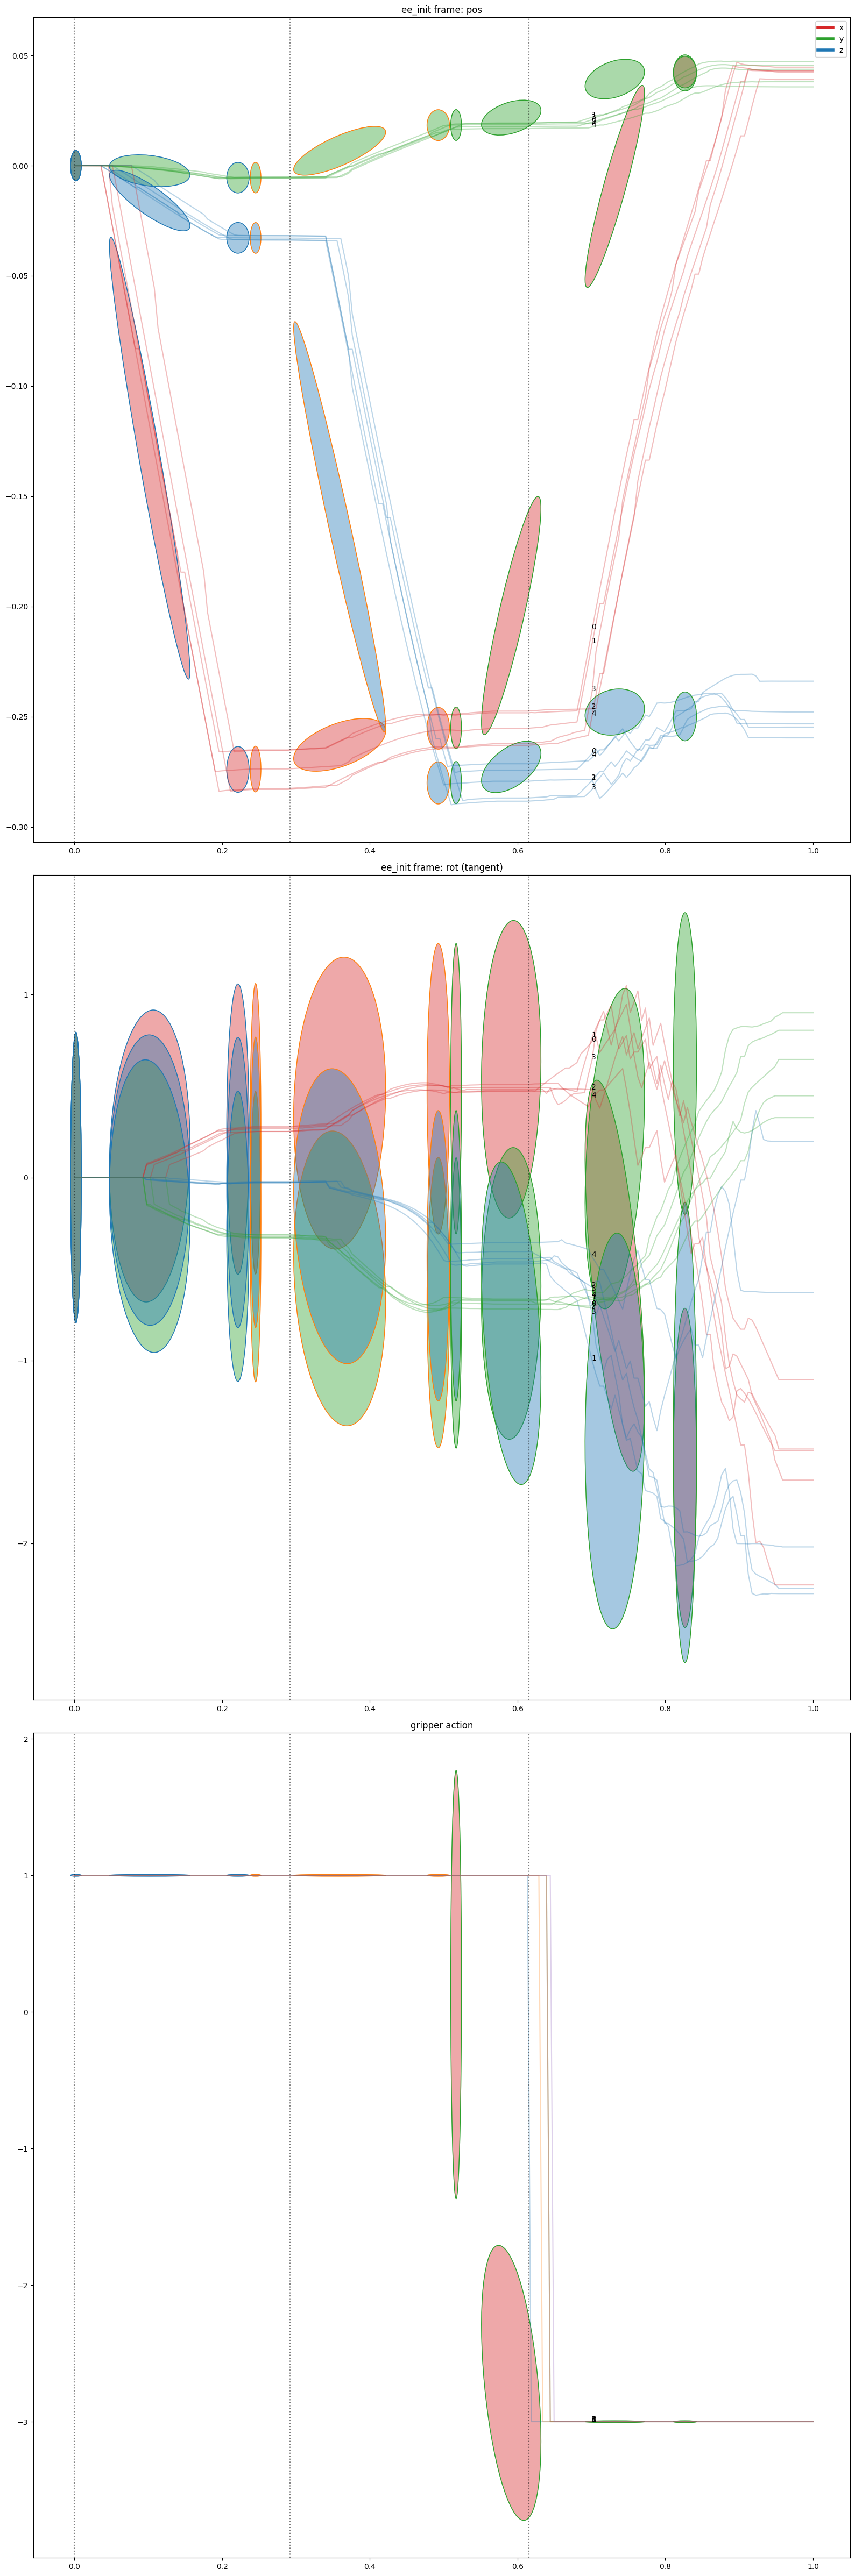

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-06-16 21:29:13.851 | INFO     |  Fitting AutoTPGMM
2025-06-16 21:29:13.852 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 21:29:13.862 | INFO     |  HMM EM ...
2025-06-16 21:29:13.866 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-06-16 21:29:13.911 | INFO     |  HMM init priors not defined, initializing to uniform
2025-06-16 21:29:15.066 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 9.98e-001, 8.57e-001, 1.85e-001, 2.14e-003, 7.93e-007,
          6.96e-012, 1.08e-018, 2.18e-027, 4.31e-038, 1.87e-051, 2.19e-068,
          8.79e-090, 1.52e-116, 1.41e-149, 8.95e-190, 8.19e-244, 1.44e-307,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.95e-001, 6.69e-001,
          5.62e-003, 2.49e-008, 7.27e-018, 1.76e-032, 4.43e-053, 1.47e-080,
          8.02e-116, 9.21e-160, 2.81e-213, 2.92e-277, 0.00e+000, 0.00e+000,
          0.

2025-06-16 21:29:32.350 | INFO     |  Did not specify time_based, deciding automatically.


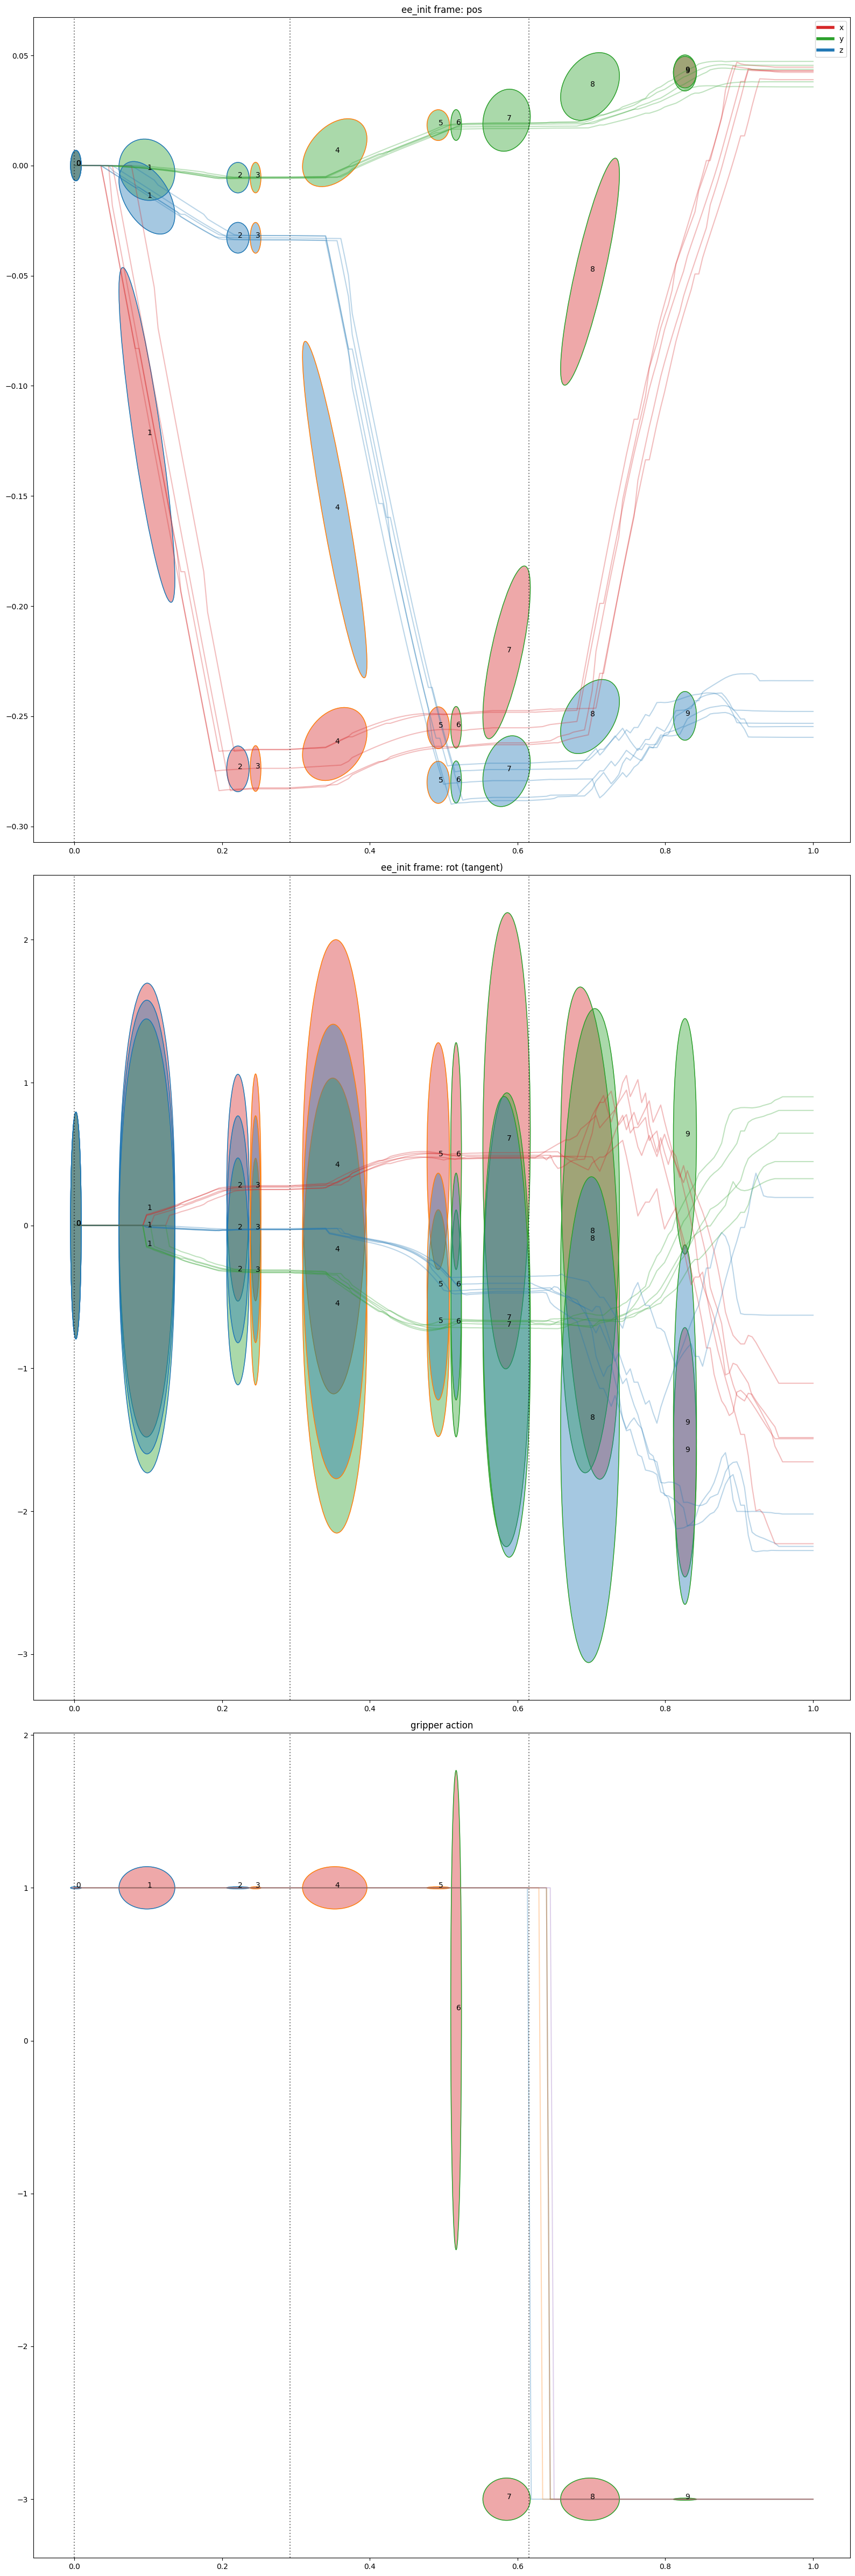

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

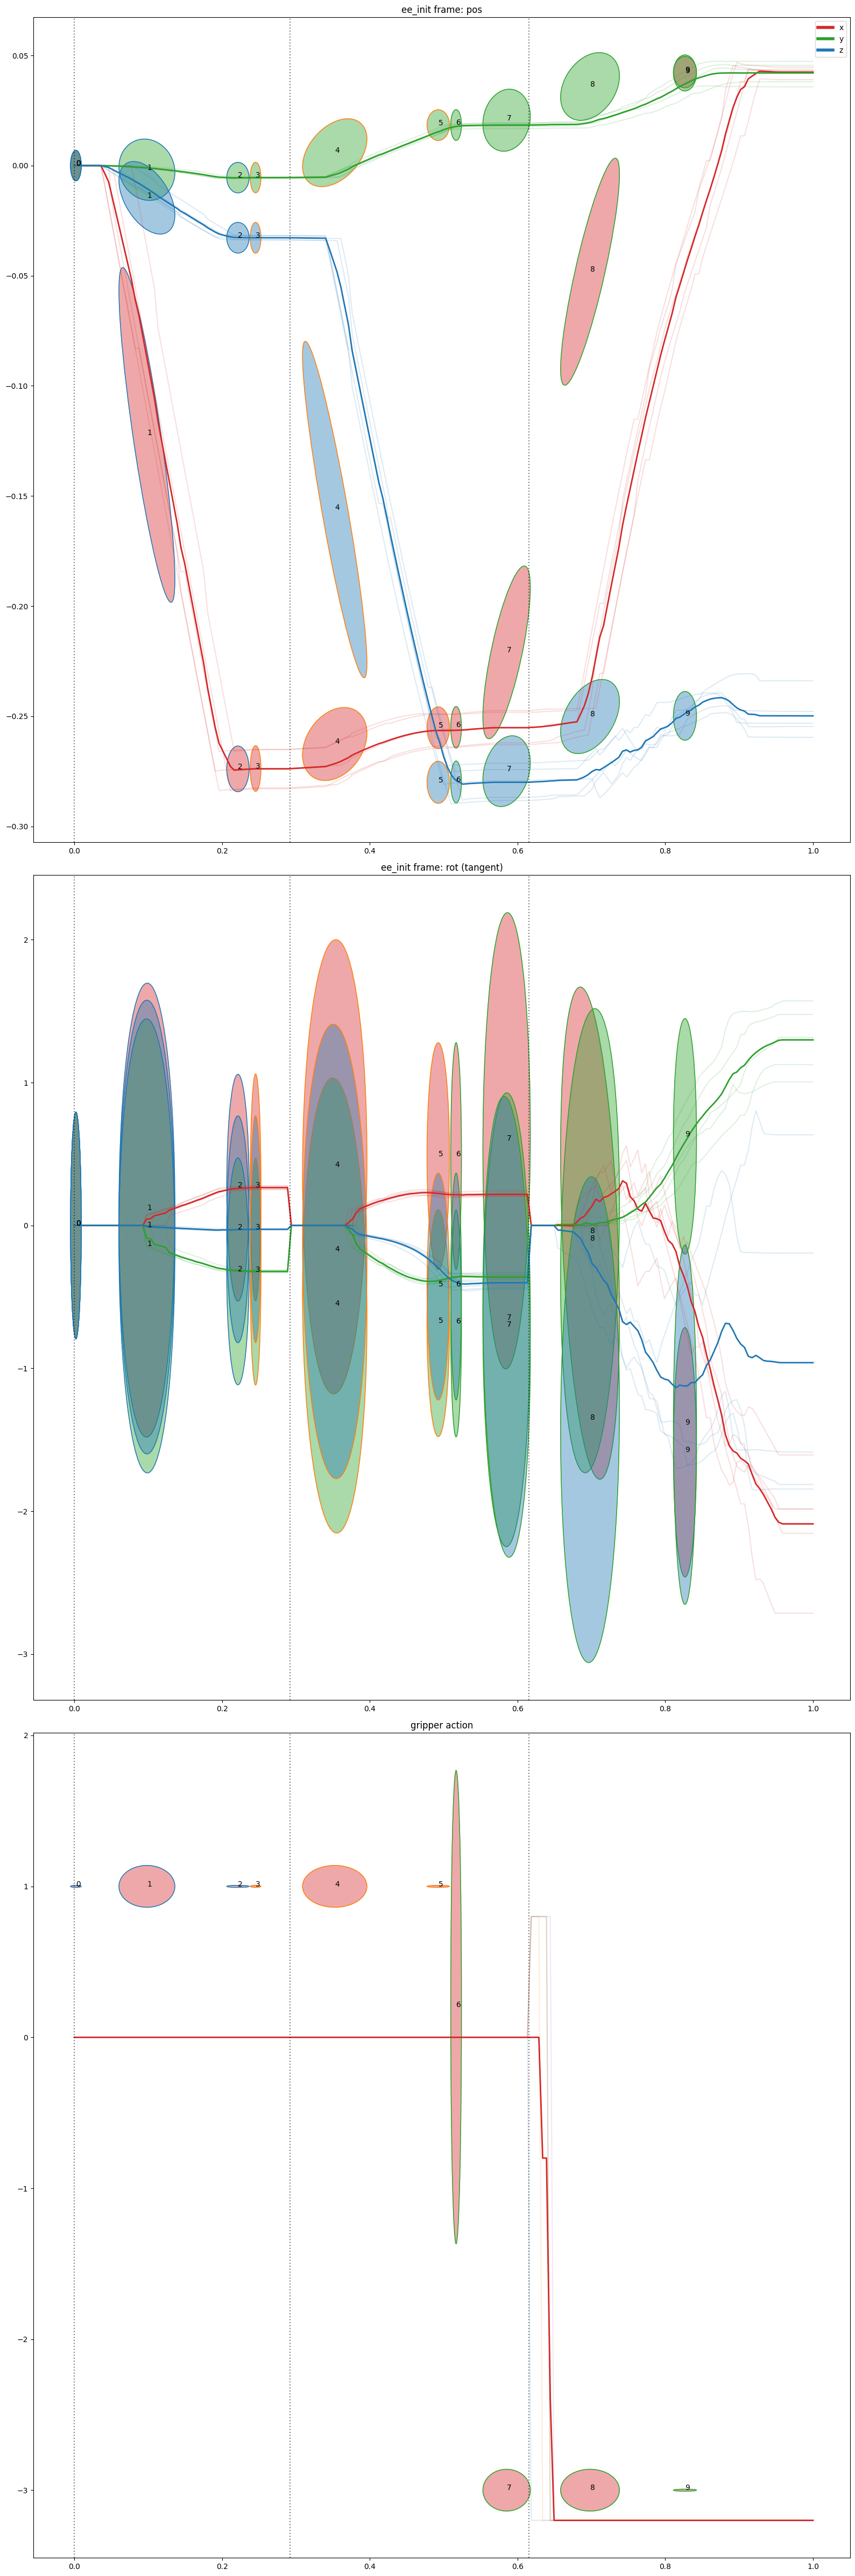

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=True, per_segment=False, gaussian_mean_only=False, plot_traj_means=True, time_based=True)

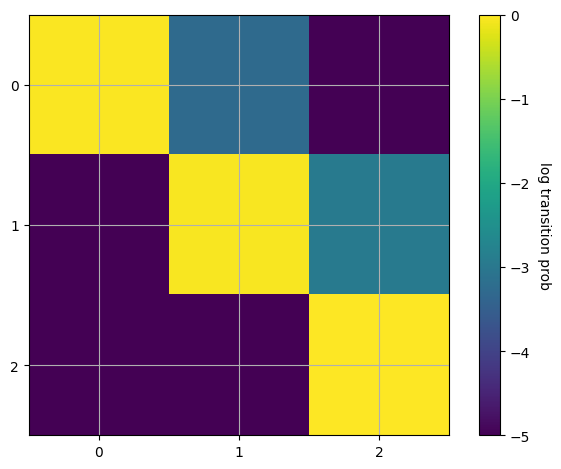

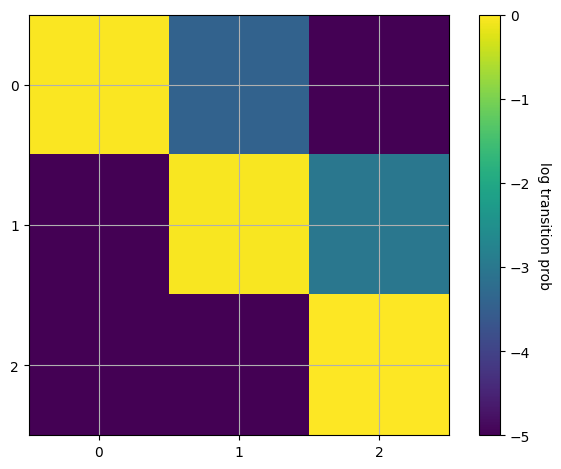

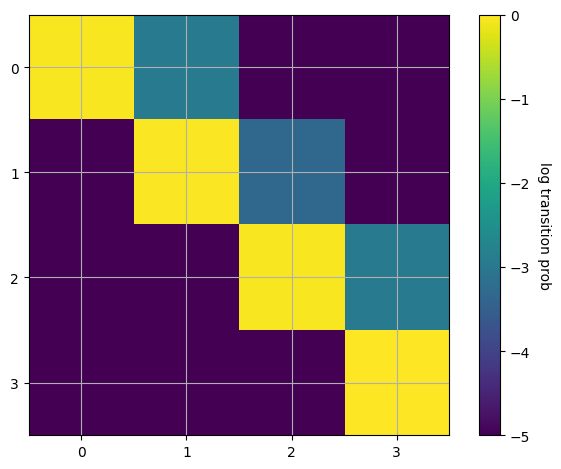

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

2025-06-16 21:29:37.720 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-06-16 21:29:37.907 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-06-16 21:30:08.555 | INFO     |  Caculated segment transition probabilities: (array([[0.]]), array([[0.]]))
2025-06-16 21:30:08.556 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-06-16 21:30:08.556 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:30:08.559 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-16 21:30:08.608 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-16 21:30:08.674 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-16 21:30:08.746 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

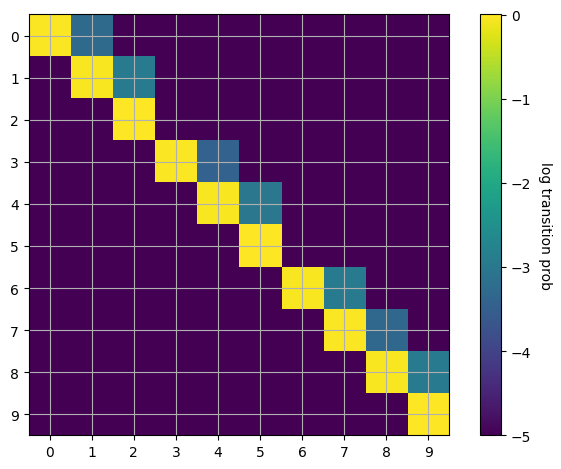

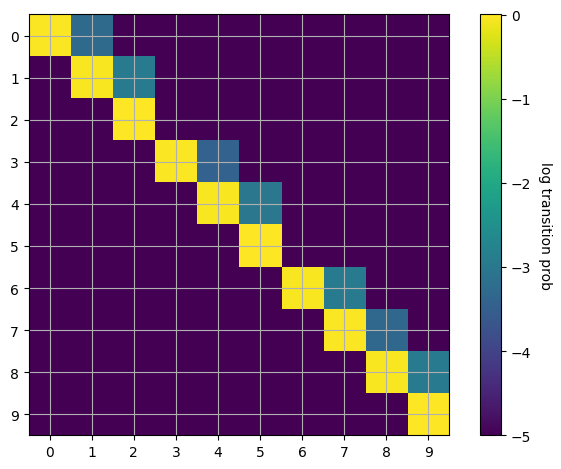

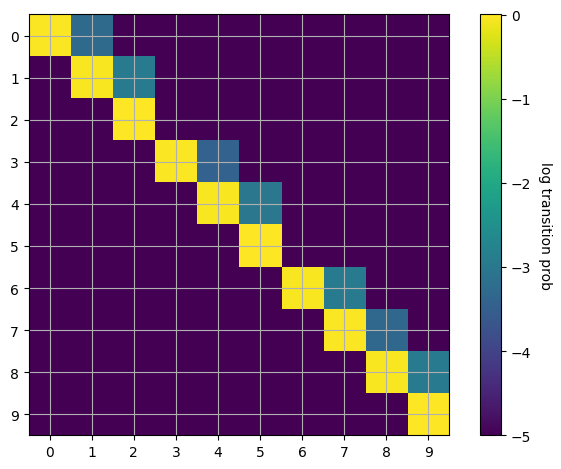

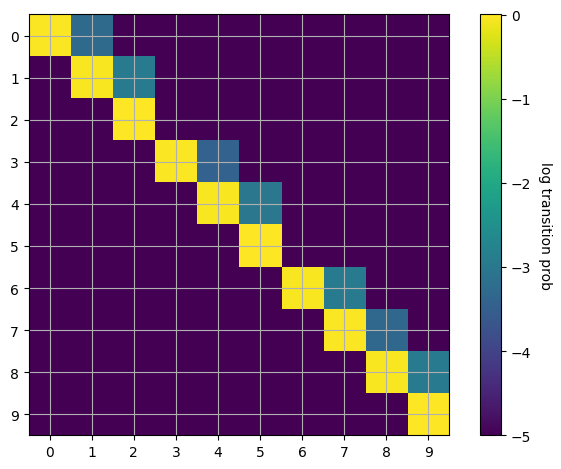

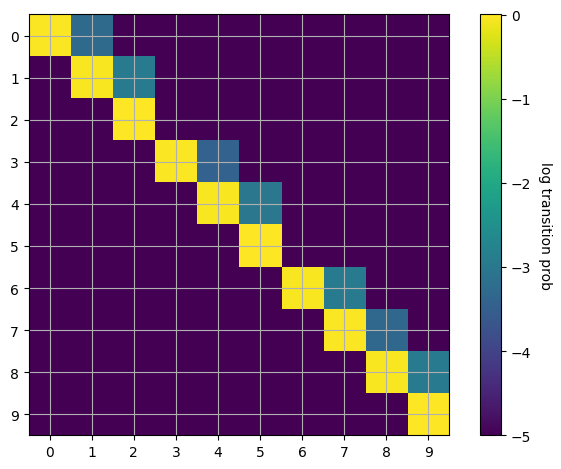

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-06-16 21:30:20.747 | INFO     |  Taking frame origins from demos.


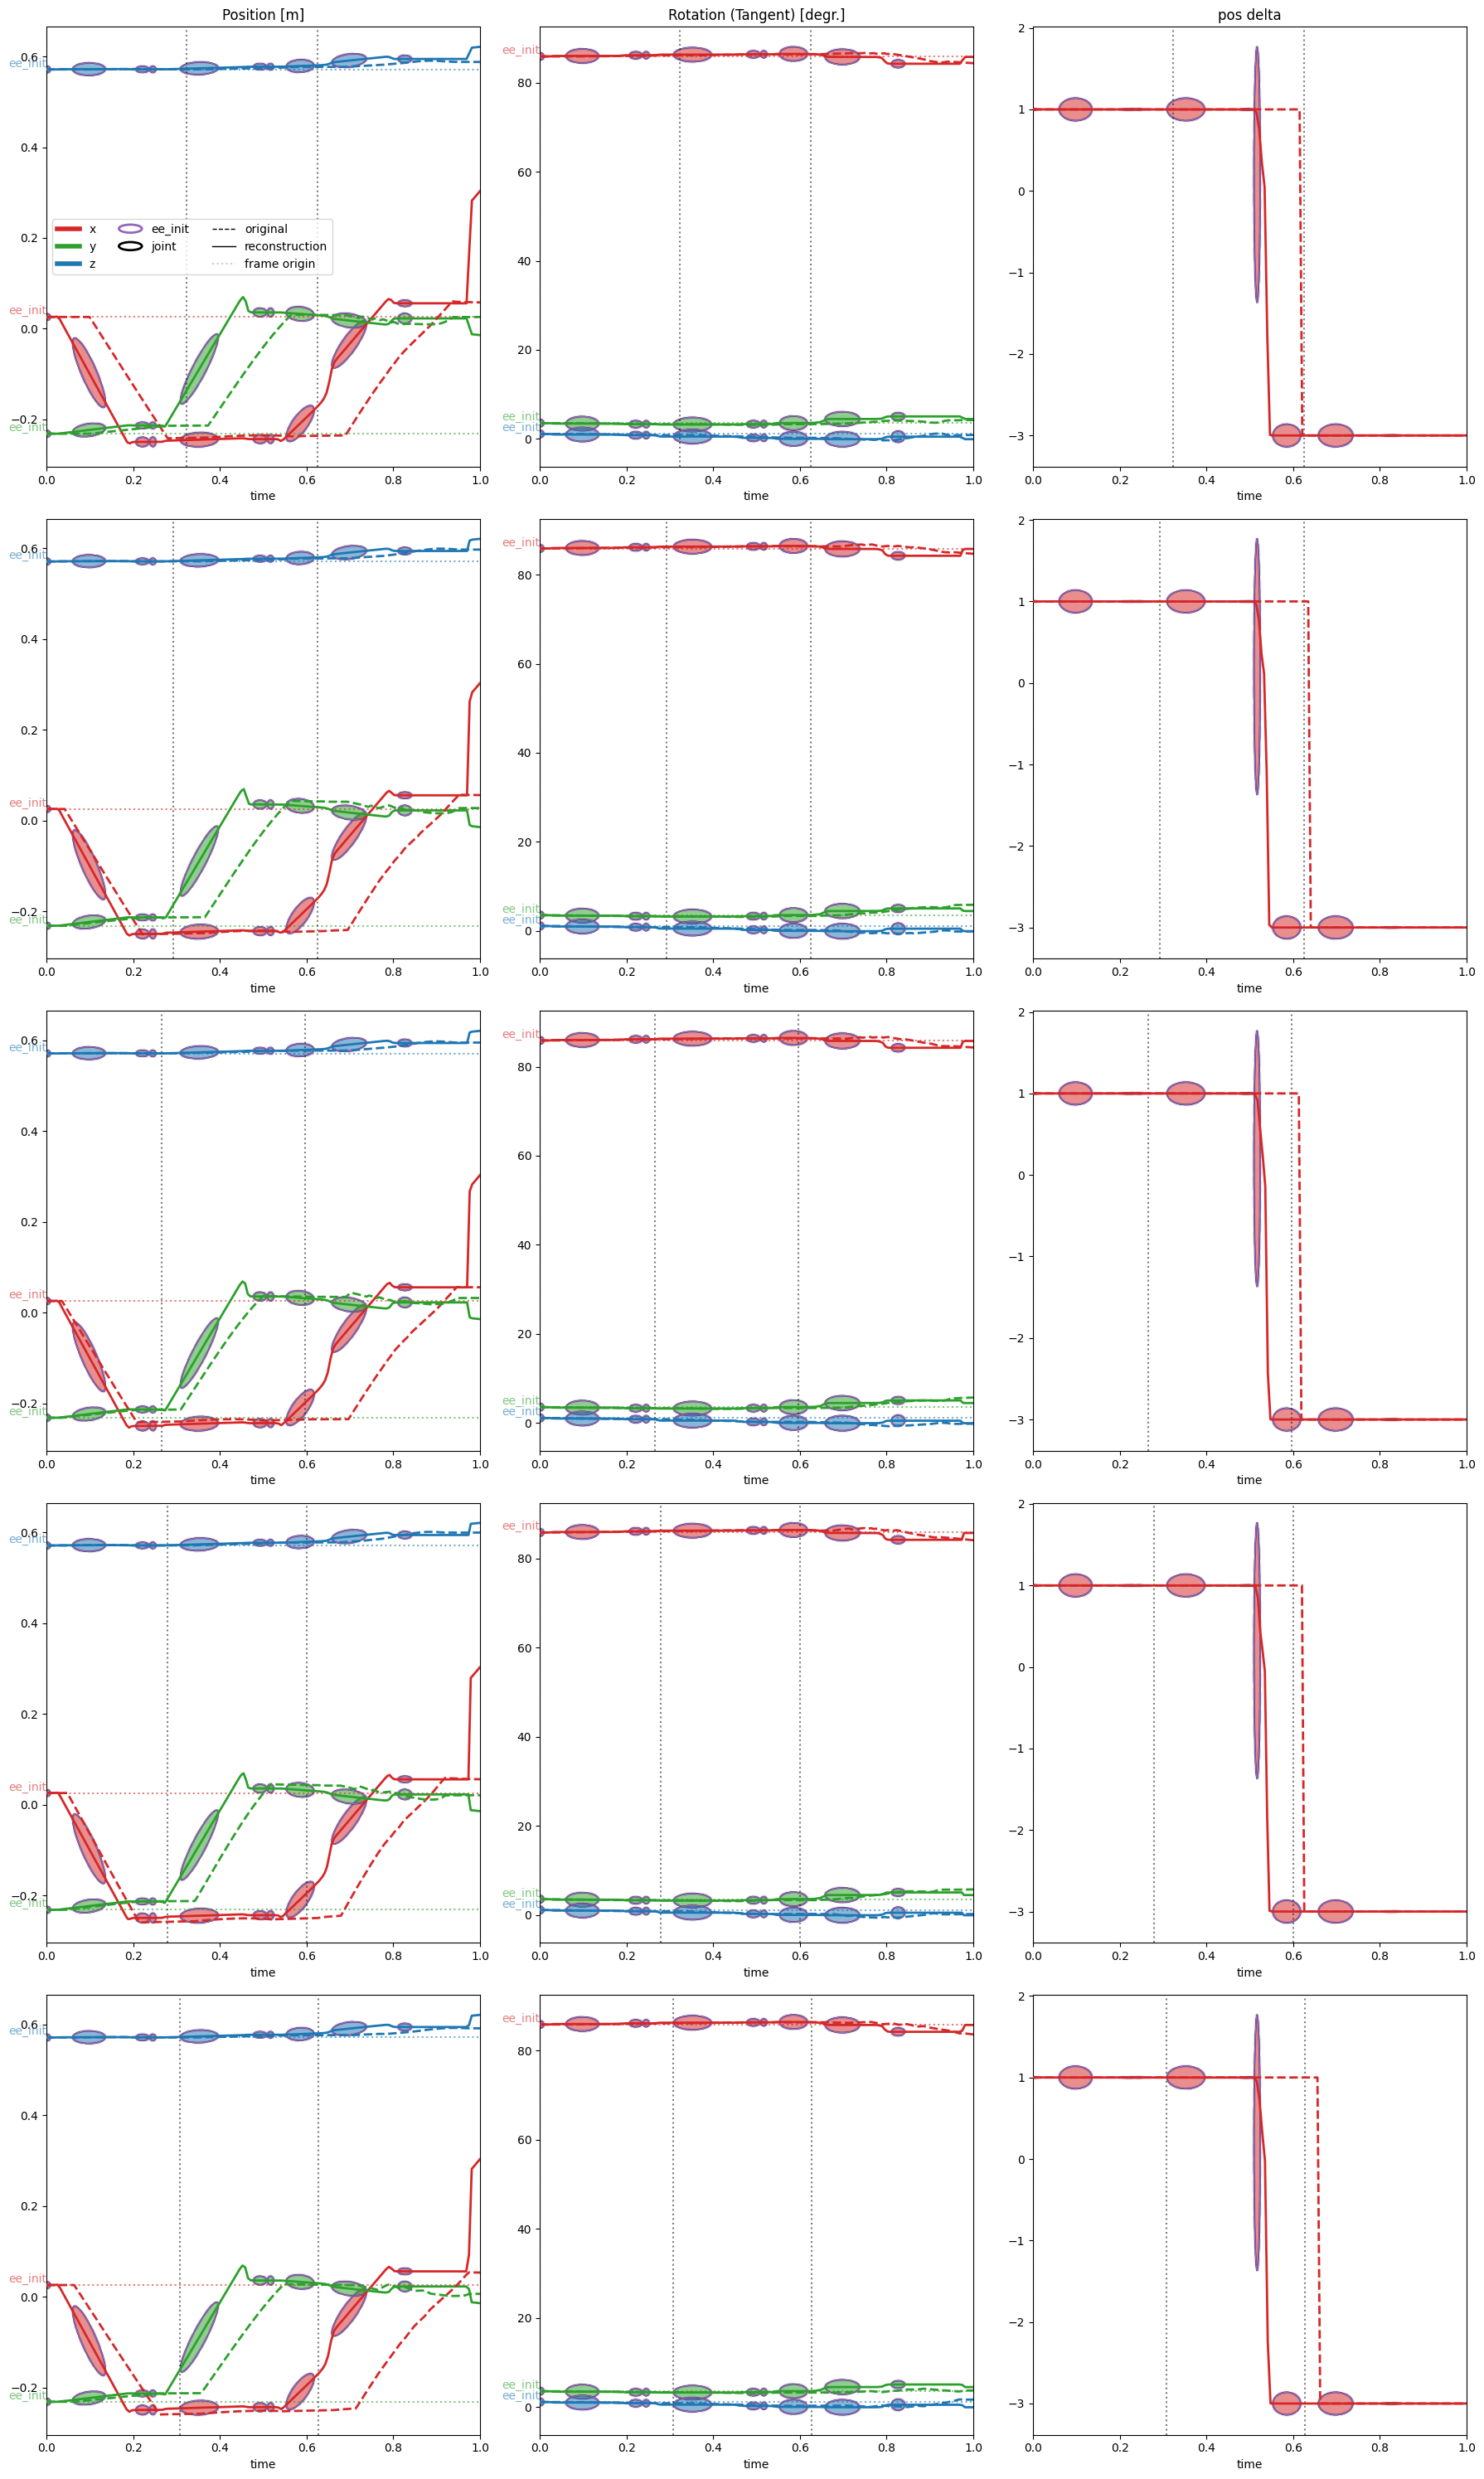

In [17]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=True,
    per_segment=False,
)

2025-06-16 21:30:30.421 | INFO     |  Taking frame origins from demos.


AttributeError: 'tuple' object has no attribute 'np_to_manifold_to_np'